In [1]:
# !pip3 install higher
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings

#The code includes extensive warnings when run so have used this to ignore them
warnings.filterwarnings("ignore")

#Set random seeds for reproducibility of results 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

Available device: cpu


In [2]:
#Neural Network Class that Ocariz wrote
class Neural_Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=1):
        super(Neural_Network, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        y = x
        return y

In [3]:
#Note that this is reused from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
#Currently in development of our own data generator
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
    
    def plot_model(self, new_model, *args, **kwargs):
        x, y_true = self.test_set(size=100)
        x = Variable(x[:, None])
        y_true = Variable(y_true[:, None])    

        y_pred = new_model(x)

        plt.plot(x.data.numpy().flatten(),
                 y_pred.data.numpy().flatten(),
                 *args, **kwargs)

TRAIN_SIZE = 20000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]

In [4]:
#Util functions that we have developed, not extensively used here

# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model


def get_samples_in_good_format(wave, num_samples=10, force_new=False):
  #This function is used to sample data from a wave
  x, y_true = wave.training_set(size=num_samples, force_new=force_new)
  # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
  # Note that we convert everything torch tensors
  x = torch.tensor(x[:,None])
  y_true = torch.tensor(y_true[:,None])
  # set to whatever the base device is (GPU or CPU)
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  return x.to(device),y_true.to(device) 

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, num_samples=10, force_new=False):
    # Get data
    x, label = get_samples_in_good_format(wave,num_samples=num_samples, force_new=force_new)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    return criterion(prediction,label)

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

In [64]:
def task_specific_train_and_eval(model, T_i, inner_loop_optimizer,K = 10, N=1, extract_task_info=False):
    
    '''
    if extract_task_info is True => return information on the initial task, and intermediate preds
    don't save for storage and compute reasons if set to False (by default)
    '''
    
    x, label = get_samples_in_good_format(T_i,num_samples=K, force_new= True)

    task_info = {}
    
    if extract_task_info == True: 
        input_coords = x.detach().numpy()[:,0]
        true_vals = sorted([(x, y) for (x, y) in zip(input_coords, label)], key=lambda x: x[0])
        
        task_info["input_coords"] = input_coords
        task_info["gt"] = true_vals
        
        # generate more points for a fine-grained evaluation of underlying func
        eval_x, eval_true_y = get_samples_in_good_format(T_i,num_samples=10000, force_new= True)
        
        eval_coords = eval_x.detach().numpy()[:,0]
        task_info["eval_coords"] = eval_coords
        task_info["gt_func"] = sorted([(x, y) for (x, y) in zip(eval_coords, eval_true_y)], key=lambda x: x[0])
        
    #Description of the loop formulation from https://higher.readthedocs.io/en/latest/toplevel.html
    with innerloop_ctx(model, inner_loop_optimizer, copy_initial_weights = False) as (fmodel,diffopt):
        #get our input data and our label
        per_step_loss = []
        for grad_step in range(N):
            
            preds = fmodel(x)
            #Get the task specific loss for our model
            task_specifc_loss = criterion(preds, label)

            #Step through the inner gradient
            diffopt.step(task_specifc_loss)
            
            per_step_loss.append(task_specifc_loss.item())
            
            if extract_task_info: 
                # use preds for new points
                preds_eval = fmodel(eval_x)
                task_preds = preds_eval.detach().numpy()[:,0]
                pred_data = sorted([(x, y) for (x, y) in zip(eval_coords, task_preds)], key=lambda x: x[0])
                task_info[f"preds_{grad_step}"] = pred_data
            
        held_out_task_specific_loss = evaluation(fmodel, T_i, num_samples=num_samples, force_new=True)
        
        return held_out_task_specific_loss, per_step_loss, fmodel, task_info

In [65]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''


#Instantiate the model network
model = Neural_Network()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

T = 25 # num tasks
N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
num_samples = 10 # number of samples to draw from the task
lr_task_specific = 0.01 # task specific learning rate
lr_meta = 0.001 # meta-update learning rate
num_epochs = 10000#70001 #Number of iterations for outer loop
printing_step = 5000 # show log of loss every x epochs

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

for epoch in range(num_epochs):
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
    waves = [SineWaveTask() for _ in range(T)]
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        held_out_task_specific_loss, _, _ = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, num_samples, N)
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
    val_wave = SineWaveTask() # our own addition -- can vary
    val_loss, _, _ = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, num_samples, N)
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "sample_maml_model.pt")

ValueError: too many values to unpack (expected 3)

(0.0, 10.0)

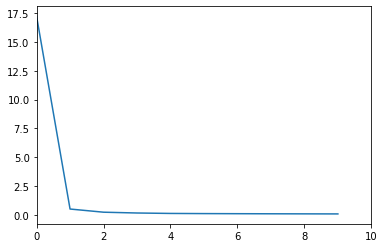

In [60]:
# run k-shot to check how rapidly we are able to adapt to unseen tasks
# starting w/ a single unseen task

# idea: re-run optimization per task multiple times to get a distribution over updates??

test_wave = SineWaveTask()
num_k_shots = 10
extract_task_info = True

K = 10

# use model returned from earlier optimization
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
held_out_task_specific_loss, metaTrainLosses, _, task_info = task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, K, num_k_shots, extract_task_info)

plt.plot(metaTrainLosses)
plt.xlim([0,num_k_shots])

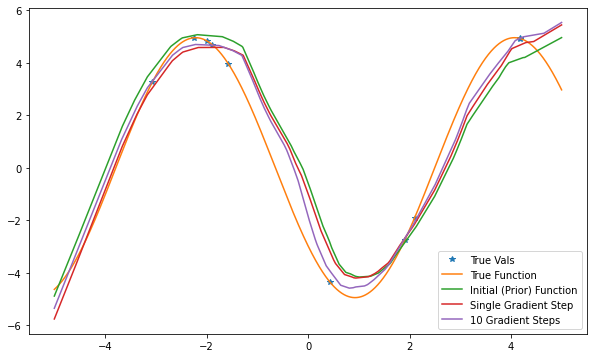

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
ax_size=16
title_size=18

true_vals = task_info["gt"]
func_gt = task_info["gt_func"]
func_prior = task_info["preds_0"]
updated_func_single = task_info["preds_1"]
updated_func_many = task_info[f"preds_{num_k_shots-1}"]

ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="True Vals")
ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="True Function")
ax.plot(np.array(func_prior)[:,0], np.array(func_prior)[:,1], label="Initial (Prior) Function")
ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="Single Gradient Step")
ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots} Gradient Steps")

ax.legend()

In [30]:
func_gt

[(-4.9999404, tensor([2.5960])),
 (-4.999785, tensor([2.5958])),
 (-4.997994, tensor([2.5926])),
 (-4.997844, tensor([2.5923])),
 (-4.9974937, tensor([2.5917])),
 (-4.9967837, tensor([2.5904])),
 (-4.995597, tensor([2.5882])),
 (-4.995578, tensor([2.5882])),
 (-4.994497, tensor([2.5863])),
 (-4.994457, tensor([2.5862])),
 (-4.994388, tensor([2.5861])),
 (-4.992843, tensor([2.5833])),
 (-4.992545, tensor([2.5827])),
 (-4.992411, tensor([2.5825])),
 (-4.9903655, tensor([2.5788])),
 (-4.989499, tensor([2.5772])),
 (-4.9894176, tensor([2.5771])),
 (-4.9890814, tensor([2.5765])),
 (-4.988577, tensor([2.5756])),
 (-4.9866652, tensor([2.5721])),
 (-4.9859447, tensor([2.5708])),
 (-4.9846845, tensor([2.5685])),
 (-4.98465, tensor([2.5684])),
 (-4.980725, tensor([2.5612])),
 (-4.9802003, tensor([2.5603])),
 (-4.979439, tensor([2.5589])),
 (-4.9790807, tensor([2.5582])),
 (-4.978199, tensor([2.5566])),
 (-4.977304, tensor([2.5549])),
 (-4.976754, tensor([2.5539])),
 (-4.9758577, tensor([2.5522])

In [ ]:
for current_func in range(T): 
    fig, ax = plt.subplots()
    data = fitted_funcs[current_func]
    true_vals = true_funcs[current_func]
    init_vals = init_funcs[current_func]
    ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], label="True Vals")
    ax.plot(np.array(init_vals)[:,0], np.array(init_vals)[:,1], label="Initial Preds")
    ax.plot(np.array(data)[:,0], np.array(data)[:,1], label="Fitted Preds")
    ax.set_title(f"Task {current_func + 1}", fontsize=16)
    ax.legend()

In [66]:
test_wave.training_set()


NameError: name 'SineWaveTask_multi' is not defined